## Problem Statement

- BoomBikes is facing revenue losses due to the COVID-19 pandemic.
- The company wants to predict demand for shared bikes post-lockdown.
- A multiple linear regression model is needed to analyze bike demand.
- Significant factors influencing bike demand must be identified.
- The model should explain how these factors affect demand variations.
- Insights from the model will help optimize business strategy and meet customer needs.
- The model will also assist in understanding demand dynamics in new markets.

In [1]:
# importing libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm 
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error


## Data Understanding and Visualisations

In [2]:
bike = pd.read_csv('day.csv')
bike

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,726,27-12-2019,1,1,12,0,4,1,2,10.420847,11.33210,65.2917,23.458911,247,1867,2114
726,727,28-12-2019,1,1,12,0,5,1,2,10.386653,12.75230,59.0000,10.416557,644,2451,3095
727,728,29-12-2019,1,1,12,0,6,0,2,10.386653,12.12000,75.2917,8.333661,159,1182,1341
728,729,30-12-2019,1,1,12,0,0,0,1,10.489153,11.58500,48.3333,23.500518,364,1432,1796


In [3]:
# instant column is an index, we can remove that.
# Also 'casual', 'registered' and 'cnt' columns, all are target variables and cnt is sum of other two columns, we can drop 'casual' and registered 'columns'.
# We only want to predict total demand for bike renatls on a particular day, it doesn't matter whether users are new or regsistered.

bike.drop(['instant', 'casual', 'registered'], axis=1, inplace=True)
bike.head()

,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,985
1,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,801
2,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,1349
3,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,1562
4,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,1600


In [4]:
bike.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   dteday      730 non-null    object 
 1   season      730 non-null    int64  
 2   yr          730 non-null    int64  
 3   mnth        730 non-null    int64  
 4   holiday     730 non-null    int64  
 5   weekday     730 non-null    int64  
 6   workingday  730 non-null    int64  
 7   weathersit  730 non-null    int64  
 8   temp        730 non-null    float64
 9   atemp       730 non-null    float64
 10  hum         730 non-null    float64
 11  windspeed   730 non-null    float64
 12  cnt         730 non-null    int64  
dtypes: float64(4), int64(8), object(1)
memory usage: 74.3+ KB


### From above information, following are the insights:
- No null value present in the dataset
- 'dteday' column is object column which needs to be converted in datetime object.
- 'season' is an integer column with values as 1,2,3,4 (1:spring, 2:summer, 3:fall, 4:winter). As there is no order, we need to convert them to original categorical values and then create dummies.
- 'yr' has 2 values - 0, 1 (0: 2018, 1: 2019), this is fine.
- 'mnth' is the month number (1 to 12). As this is ordinal, hence keep it as it is.
- 'holiday', 'weekday', 'workingday' columns are fine. We can make a new column for 'weekend' if it is necessary, we will see it later.
- 'weathersit' is weather situaltion with values 1,2,3,4 (1: Clear, partly cloudy, 2: Mist, cloudy, 3: Light rain/snow, thunderstorm, 4: Heavy rain/snow). We can clearly see that there is some sort of order, hence keep this as it is.
- all other columns are fine.


In [5]:
# convert 'dteday' col to datetime objbect
bike['dteday'] = pd.to_datetime(bike['dteday'], format='%d-%m-%Y')

# map values in 'season' column
bike['season'] = bike['season'].map({1:'spring', 2:'summer', 3:'fall', 4:'winter'})

bike.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   dteday      730 non-null    datetime64[ns]
 1   season      730 non-null    object        
 2   yr          730 non-null    int64         
 3   mnth        730 non-null    int64         
 4   holiday     730 non-null    int64         
 5   weekday     730 non-null    int64         
 6   workingday  730 non-null    int64         
 7   weathersit  730 non-null    int64         
 8   temp        730 non-null    float64       
 9   atemp       730 non-null    float64       
 10  hum         730 non-null    float64       
 11  windspeed   730 non-null    float64       
 12  cnt         730 non-null    int64         
dtypes: datetime64[ns](1), float64(4), int64(7), object(1)
memory usage: 74.3+ KB


In [6]:
bike

,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,2018-01-01,spring,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,985
1,2018-01-02,spring,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,801
2,2018-01-03,spring,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,1349
3,2018-01-04,spring,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,1562
4,2018-01-05,spring,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,1600
...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,2019-12-27,spring,1,12,0,4,1,2,10.420847,11.33210,65.2917,23.458911,2114
726,2019-12-28,spring,1,12,0,5,1,2,10.386653,12.75230,59.0000,10.416557,3095
727,2019-12-29,spring,1,12,0,6,0,2,10.386653,12.12000,75.2917,8.333661,1341
728,2019-12-30,spring,1,12,0,0,0,1,10.489153,11.58500,48.3333,23.500518,1796


In [7]:
bike.describe()

,dteday,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
count,730,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,2018-12-31 12:00:00,0.500000,6.526027,0.028767,2.997260,0.683562,1.394521,20.319259,23.726322,62.765175,12.763620,4508.006849
min,2018-01-01 00:00:00,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.424346,3.953480,0.000000,1.500244,22.000000
25%,2018-07-02 06:00:00,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,13.811885,16.889713,52.000000,9.041650,3169.750000
50%,2018-12-31 12:00:00,0.500000,7.000000,0.000000,3.000000,1.000000,1.000000,20.465826,24.368225,62.625000,12.125325,4548.500000
75%,2019-07-01 18:00:00,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,26.880615,30.445775,72.989575,15.625589,5966.000000
max,2019-12-31 00:00:00,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,35.328347,42.044800,97.250000,34.000021,8714.000000
std,NaN,0.500343,3.450215,0.167266,2.006161,0.465405,0.544807,7.506729,8.150308,14.237589,5.195841,1936.011647


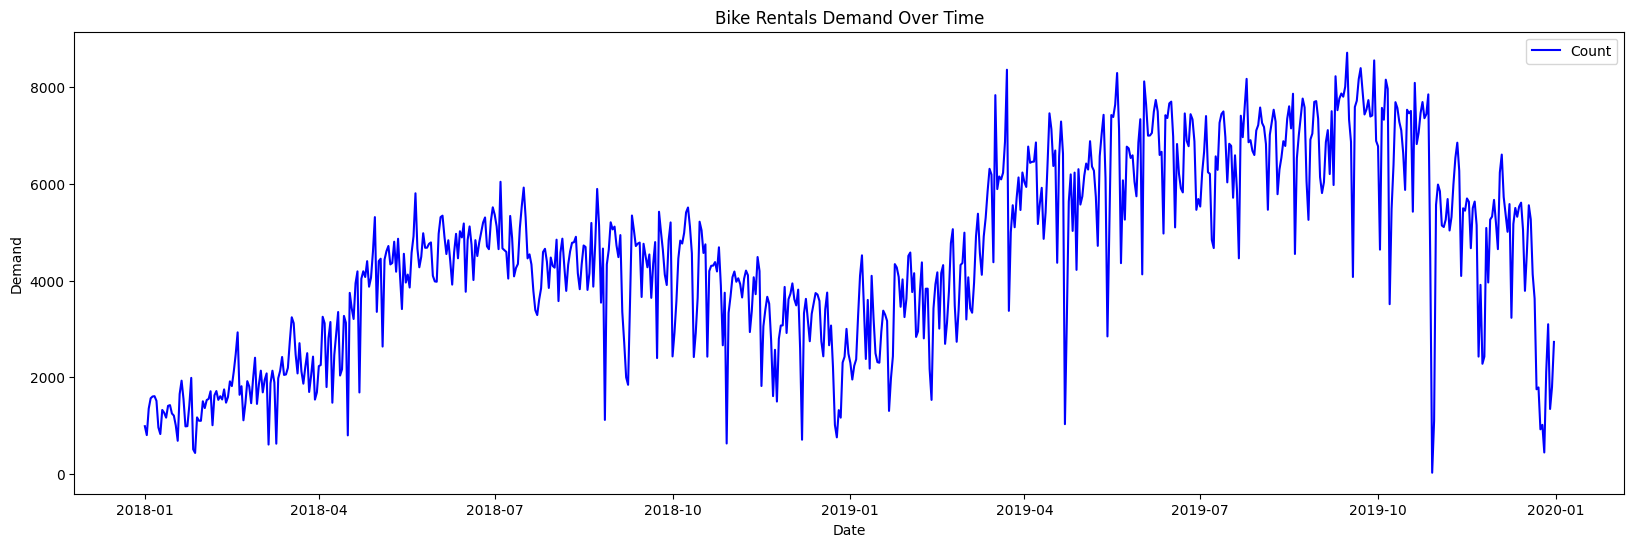

In [8]:
plt.figure(figsize=(20, 6))
plt.plot(bike['dteday'], bike['cnt'], label='Count', color='blue')
plt.xlabel('Date')
plt.ylabel('Demand')
plt.title('Bike Rentals Demand Over Time')
plt.legend()
plt.show()

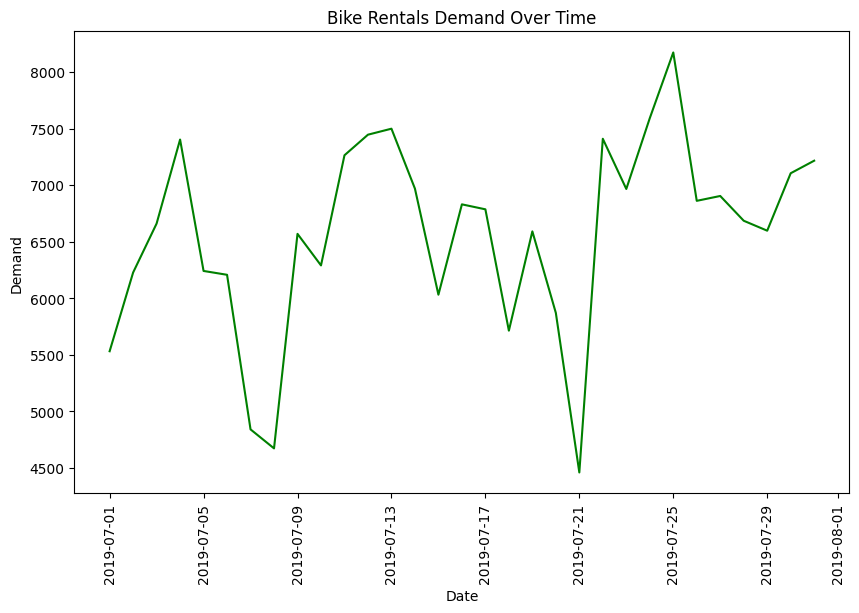

In [9]:
filtered_bike = bike[(bike['dteday'] >= '2019-07-01') & (bike['dteday'] <= '2019-07-31')]
plt.figure(figsize=(10, 6))
plt.plot(filtered_bike['dteday'], filtered_bike['cnt'], label='Count', color='green')
plt.xlabel('Date')
plt.ylabel('Demand')
plt.title('Bike Rentals Demand Over Time')
plt.xticks(rotation=90)
plt.show()

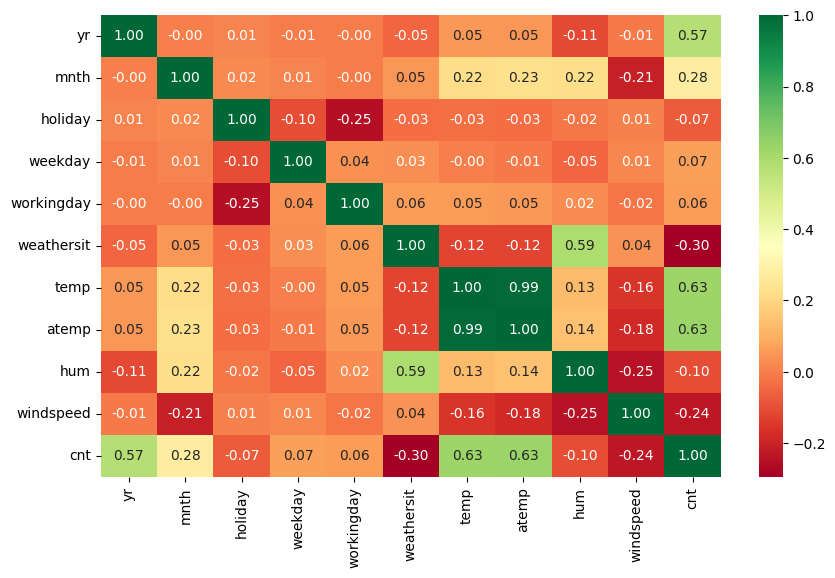

In [10]:
plt.figure(figsize=(10, 6))
bike_corr = bike.select_dtypes(include=['number']).corr()
sns.heatmap(bike_corr, annot=True, cmap='RdYlGn', fmt='.2f')
plt.show()

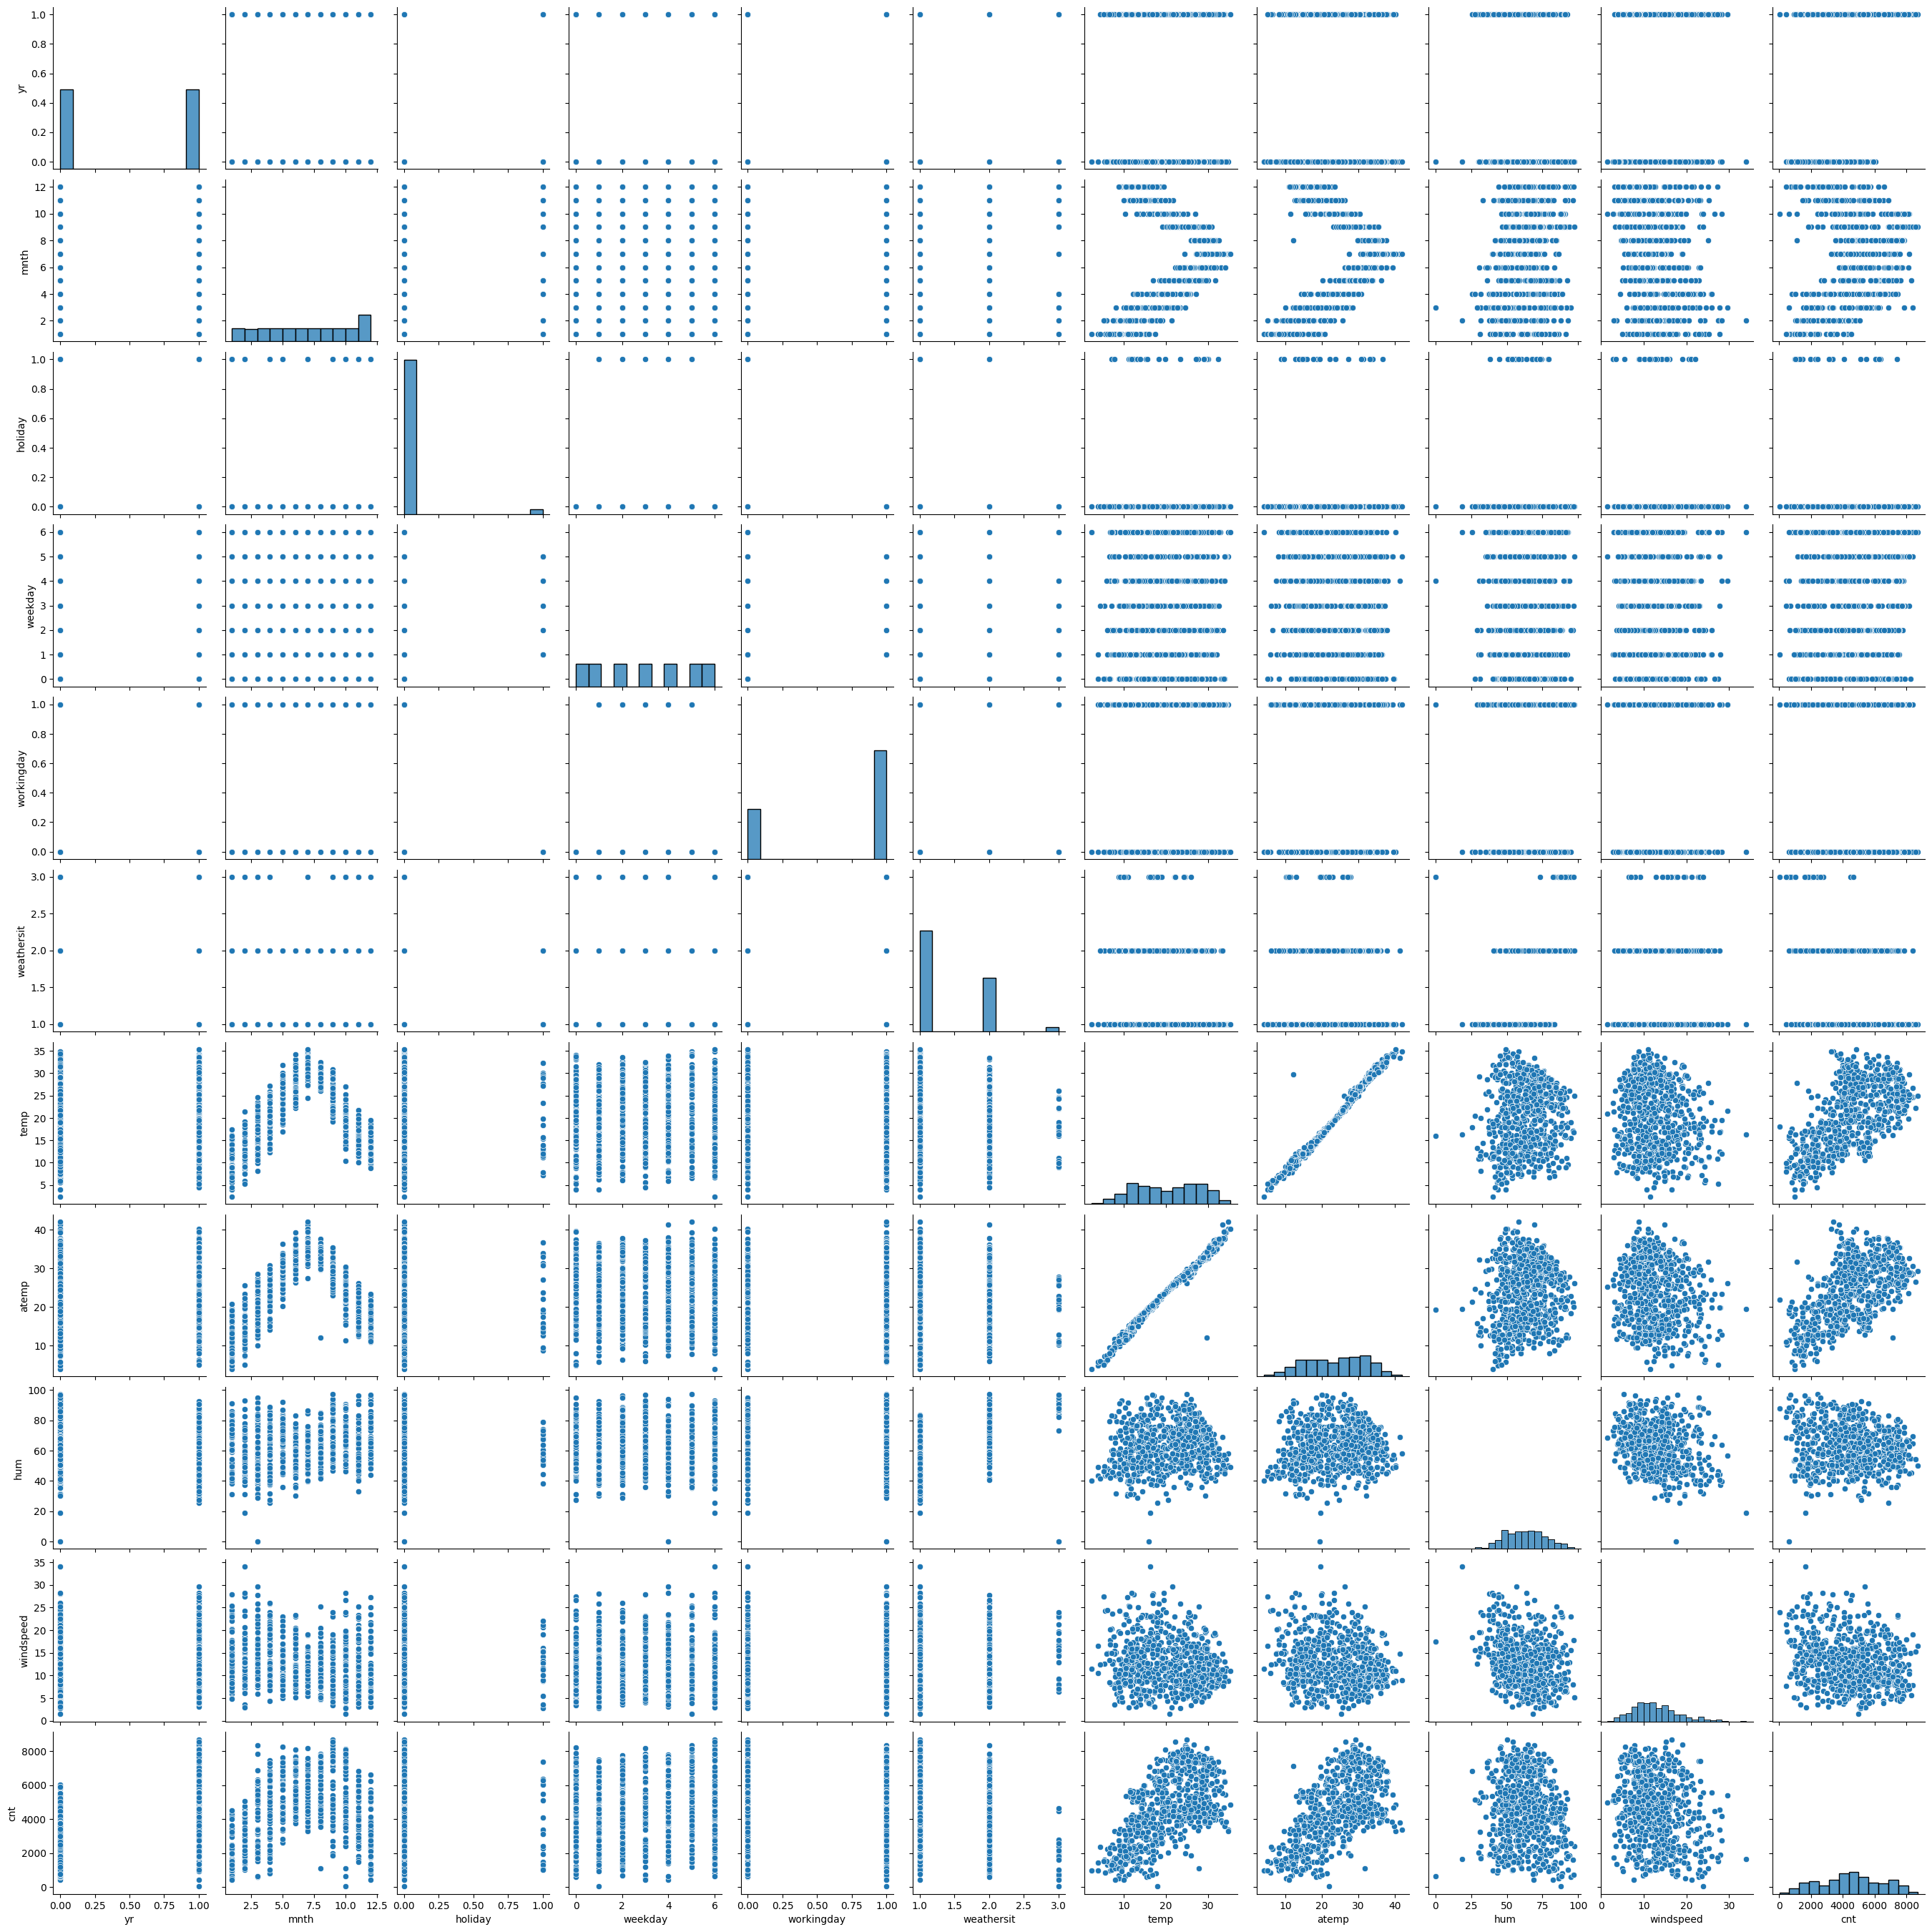

In [11]:
sns.pairplot(bike)

From the pairplot, we can infer the followings:
- yr - 1 (2019) had high demands.
- in summer months, demand was higher as compared to winter months
- demand was higher when there were no holidays (0) as comapred to that on holidays (1). This maybe due to holiday (1) accounts very less % in the data.
- 'weekday', 'workingday' features have almost no significant impact on demand, while in case of workingday=0 (non working day), demand is little bit higher than that of workingday=1 (working day)
- 'weathersit' has impact on demand. When weathersit=3 (Light rain/snow, thunderstorm), demand was less.
- 'temp' and 'cnt' is linearly correlated and same is with 'atemp' and 'cnt'.
- 'temp' & 'atemp' input features are perfectly correalted to each other.
- 'hum' & 'windspeed' couldn't impact the demand much.


In [12]:
# First, 'temp' and 'atemp' are highly correlated to each other (0.99) which is almost perfectly linear and this is case of multicolinearity.
# Also, correlation between 'temp' and 'cnt' is 0.63 and betwen 'atemp' and 'cnt' is also 0.63.
# Hence, we can remove one column - 'atemp' 
bike.drop('atemp', axis=1, inplace=True)

C:\Users\User\AppData\Local\Temp\ipykernel_16316\2078097402.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp_demand = bike_temp.groupby('temp_bins')['cnt'].mean().reset_index()


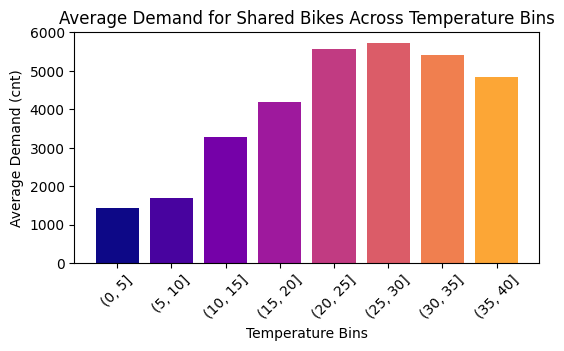

In [13]:
bike_temp = bike[['temp', 'cnt']].copy()
bike_temp['temp_bins'] = pd.cut(bike_temp['temp'], bins=np.arange(0, 41, 5)) 

# Calculate mean demand for each temperature bin
temp_demand = bike_temp.groupby('temp_bins')['cnt'].mean().reset_index()

# Plotting the results
plt.figure(figsize=(6, 3))
colors = plt.cm.plasma(np.linspace(0, 0.8, len(temp_demand)))
plt.bar(temp_demand['temp_bins'].astype(str), temp_demand['cnt'], color=colors)
plt.xlabel('Temperature Bins')
plt.ylabel('Average Demand (cnt)')
plt.title('Average Demand for Shared Bikes Across Temperature Bins')
plt.xticks(rotation=45)
plt.show()

max temp in the datatset is 35.32°C

C:\Users\User\AppData\Local\Temp\ipykernel_16316\66139416.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bike_temp_avg, x='temp_category', y='cnt', palette='muted')


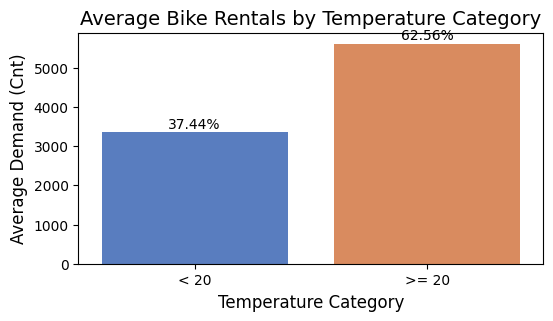

In [14]:
# Create a Bar plot between cnt and temp_category

bike_temp['temp_category'] = bike_temp['temp'].apply(lambda x: '< 20' if x < 20 else '>= 20')
bike_temp_avg = bike_temp.groupby('temp_category', as_index=False)['cnt'].mean()
bike_temp_avg['cnt'] = bike_temp_avg['cnt'].round(2)
bike_temp_avg['percentage'] = round((bike_temp_avg['cnt'] / bike_temp_avg['cnt'].sum()) * 100, 2)

plt.figure(figsize=(6, 3))
sns.barplot(data=bike_temp_avg, x='temp_category', y='cnt', palette='muted')

# Add percentage annotations
for index, row in bike_temp_avg.iterrows():
    plt.text(index, row['cnt'] + 100, f"{row['percentage']:.2f}%", ha='center', fontsize=10)

# Add labels and title
plt.xlabel('Temperature Category', fontsize=12)
plt.ylabel('Average Demand (Cnt)', fontsize=12)
plt.title('Average Bike Rentals by Temperature Category', fontsize=14)
plt.show()

max temp in the datatset is 35.32°C

C:\Users\User\AppData\Local\Temp\ipykernel_16316\1970462013.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bike_yr_avg, x='yr', y='cnt', palette='twilight')


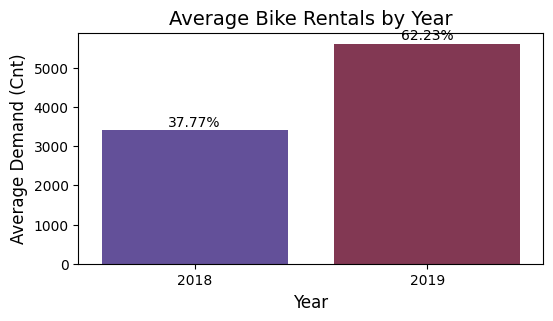

In [15]:
# Create a bar plot for 'yr' vs. 'cnt'

bike_yr = bike[['yr', 'cnt']].copy()
bike_yr['yr'] = bike_yr['yr'].map({0: 2018, 1: 2019})

bike_yr_avg = bike_yr.groupby('yr', as_index=False)['cnt'].mean()
bike_yr_avg['cnt'] = bike_yr_avg['cnt'].round(2)
bike_yr_avg['percentage'] = round((bike_yr_avg['cnt'] / bike_yr_avg['cnt'].sum()) * 100, 2)

plt.figure(figsize=(6, 3))
sns.barplot(data=bike_yr_avg, x='yr', y='cnt', palette='twilight')

# Add percentage annotations
for index, row in bike_yr_avg.iterrows():
    plt.text(index, row['cnt'] + 100, f"{row['percentage']:.2f}%", ha='center', fontsize=10)

# Add labels and title
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Demand (Cnt)', fontsize=12)
plt.title('Average Bike Rentals by Year', fontsize=14)
plt.show()

Clearly, 2019 has higher demand than 2018.

C:\Users\User\AppData\Local\Temp\ipykernel_16316\2978313450.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bike_season_avg, x='season', y='cnt', palette='muted')


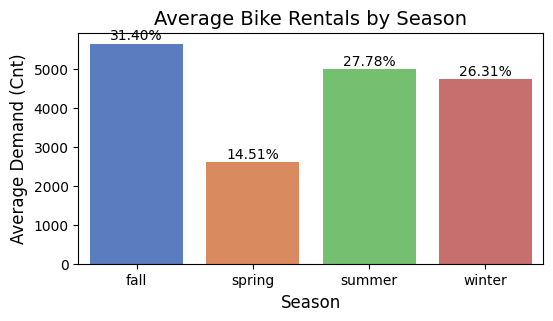

In [16]:
# Create a bar plot for 'season' vs. 'cnt'

bike_season = bike[['season', 'cnt']].copy()
bike_season_avg = bike_season.groupby('season', as_index=False)['cnt'].mean()
bike_season_avg['cnt'] = bike_season_avg['cnt'].round(2)
bike_season_avg['percentage'] = round((bike_season_avg['cnt'] / bike_season_avg['cnt'].sum()) * 100, 2)

plt.figure(figsize=(6, 3))
sns.barplot(data=bike_season_avg, x='season', y='cnt', palette='muted')

# Add percentage annotations
for index, row in bike_season_avg.iterrows():
    plt.text(index, row['cnt'] + 100, f"{row['percentage']:.2f}%", ha='center', fontsize=10)

# Add labels and title
plt.xlabel('Season', fontsize=12)
plt.ylabel('Average Demand (Cnt)', fontsize=12)
plt.title('Average Bike Rentals by Season', fontsize=14)
plt.show()

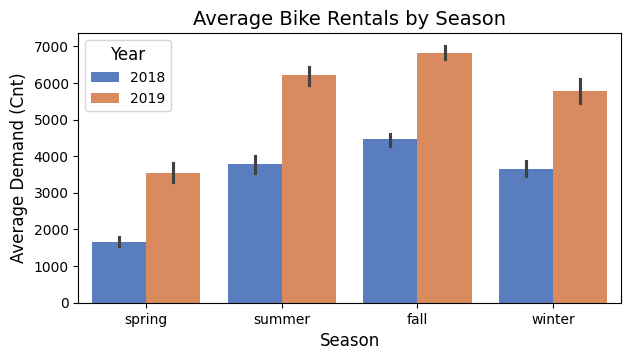

In [17]:
# Create a bar plot for 'season' vs. 'cnt'
plt.figure(figsize=(7, 3.5))
plot = sns.barplot(data=bike, x='season', y='cnt', palette='muted', hue='yr')

# Add labels and title
plt.xlabel('Season', fontsize=12)
plt.ylabel('Average Demand (Cnt)', fontsize=12)
plt.title('Average Bike Rentals by Season', fontsize=14)
legend_labels = {0: '2018', 1: '2019'}
handles, labels = plot.get_legend_handles_labels()
plt.legend(handles, [legend_labels[int(label)] for label in labels], title='Year', fontsize=10, title_fontsize=12)
plt.show()

We can clearly say, sequence of demand as per season is:
fall > summer > winter > spring

C:\Users\User\AppData\Local\Temp\ipykernel_16316\1130019882.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bike, x='workingday', y='cnt', palette='muted')


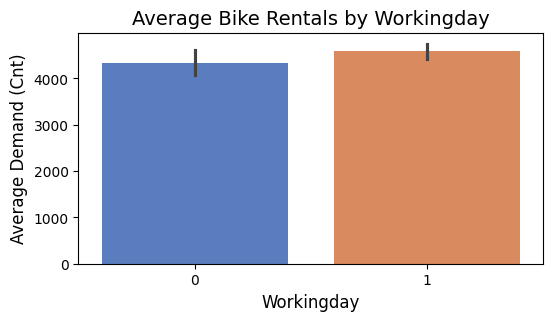

In [18]:
# Create a bar plot for 'workingday' vs. 'cnt'
plt.figure(figsize=(6, 3))
sns.barplot(data=bike, x='workingday', y='cnt', palette='muted')

# Add labels and title
plt.xlabel('Workingday', fontsize=12)
plt.ylabel('Average Demand (Cnt)', fontsize=12)
plt.title('Average Bike Rentals by Workingday', fontsize=14)
plt.show()

From above visualisation, there is almost no impact of whether it is workingday or not on demand of bike rentals.

C:\Users\User\AppData\Local\Temp\ipykernel_16316\2565846232.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bike, x='weathersit', y='cnt', palette='muted')


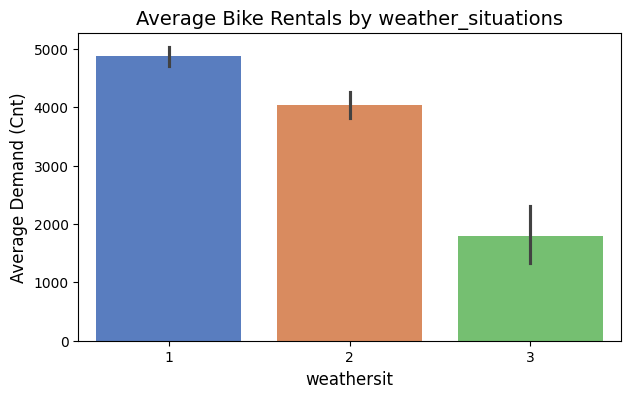

In [19]:
# Create a bar plot for 'weathersit' vs. 'cnt'
plt.figure(figsize=(7, 4))
sns.barplot(data=bike, x='weathersit', y='cnt', palette='muted')

# Add labels and title
plt.xlabel('weathersit', fontsize=12)
plt.ylabel('Average Demand (Cnt)', fontsize=12)
plt.title('Average Bike Rentals by weather_situations', fontsize=14)
plt.show()

in clear weather, demand is higher. in Mist or cloudy weather, demand is moderate and it is very less in case of rain/snow or thunderstorm.

#### EDA is completed

## Linear regression Model Preparation

In [20]:
# Create Dummy variables
season_dummies = pd.get_dummies(bike['season'], prefix='season', drop_first=True).astype(int)
bike = pd.concat([bike, season_dummies], axis=1)
bike = bike.drop(['season'], axis=1)
bike.head()

,dteday,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt,season_spring,season_summer,season_winter
0,2018-01-01,0,1,0,6,0,2,14.110847,80.5833,10.749882,985,1,0,0
1,2018-01-02,0,1,0,0,0,2,14.902598,69.6087,16.652113,801,1,0,0
2,2018-01-03,0,1,0,1,1,1,8.050924,43.7273,16.636703,1349,1,0,0
3,2018-01-04,0,1,0,2,1,1,8.200000,59.0435,10.739832,1562,1,0,0
4,2018-01-05,0,1,0,3,1,1,9.305237,43.6957,12.522300,1600,1,0,0


In [21]:
# Extracting 'day_of_month' from date and droppinmg 'dteday' column as model doesn't understand datetime object.
# we already have month and year columns
bike['day_of_month'] = bike['dteday'].dt.day
bike.drop('dteday', axis=1, inplace=True)

In [22]:
# Train Test split
X = bike.drop('cnt', axis=1)
y = bike['cnt']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X_train

,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,season_spring,season_summer,season_winter,day_of_month
653,1,10,0,2,1,1,19.201653,55.8333,12.208807,0,0,1,16
668,1,10,0,3,1,2,14.657500,66.6667,11.166689,0,0,1,31
694,1,11,0,1,1,1,12.846653,53.5417,3.125550,0,0,1,26
212,0,8,0,1,1,1,31.638347,55.0833,10.500039,0,0,0,1
18,0,1,0,3,1,2,11.979134,74.1739,13.957239,1,0,0,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,0,3,0,0,0,1,15.758268,52.7391,18.130468,1,0,0,13
106,0,4,0,0,0,1,18.723347,47.9583,20.334232,0,1,0,17
270,0,9,0,3,1,2,26.035000,84.8750,9.958143,0,0,1,28
435,1,3,0,1,1,1,19.133347,48.9167,13.916771,1,0,0,12


In [23]:
# Scaling all the input features to bring all the values in one range for simlicity.

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# fit_transform the sclaer in X_train
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_train_1 = sm.add_constant(X_train)
X_train_1.head()

# transform the sclaer in X_test. We don't fit scaler in test data.
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)
X_test_1 = sm.add_constant(X_test)

In [24]:
#First model - lr1

lr1 = sm.OLS(y_train, X_train_1).fit()
print(lr1.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.820
Model:                            OLS   Adj. R-squared:                  0.816
Method:                 Least Squares   F-statistic:                     187.1
Date:                Mon, 27 Jan 2025   Prob (F-statistic):          6.33e-189
Time:                        16:10:06   Log-Likelihood:                -4447.7
No. Observations:                 547   AIC:                             8923.
Df Residuals:                     533   BIC:                             8984.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          4550.2413     35.619    127.746

In [25]:
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

vif_data = pd.DataFrame()
vif_data['Feature'] = X_train_1.columns
vif_data['VIF'] = [vif(X_train_1.values, i) for i in range(X_train_1.shape[1])]
vif_data.sort_values(by='VIF', ascending=False)

,Feature,VIF
10,season_spring,5.702281
2,mnth,3.608579
12,season_winter,3.511204
7,temp,3.504485
11,season_summer,2.438278
8,hum,1.878940
6,weathersit,1.719726
9,windspeed,1.189821
3,holiday,1.086601
5,workingday,1.085866


As we can see, mnth and day_of_month have higher p-values and also mnth has a VIF of 3.61. We priorotize p-value, hence we can remove mnth column and then we will check R-square.

In [26]:
# model lr2

X_train_2 = X_train_1.drop('mnth', axis=1)
lr2 = sm.OLS(y_train, X_train_2).fit()
print(lr2.summary())

X_test_2 = X_test_1.drop('mnth', axis=1)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.819
Model:                            OLS   Adj. R-squared:                  0.815
Method:                 Least Squares   F-statistic:                     201.9
Date:                Mon, 27 Jan 2025   Prob (F-statistic):          1.52e-189
Time:                        16:10:06   Log-Likelihood:                -4449.0
No. Observations:                 547   AIC:                             8924.
Df Residuals:                     534   BIC:                             8980.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          4550.2413     35.670    127.565

day_of_month still has high p-value, we can remove this column as well.

In [27]:
# model lr3

X_train_3 = X_train_2.drop('day_of_month', axis=1)
lr3 = sm.OLS(y_train, X_train_3).fit()
print(lr3.summary())

X_test_3 = X_test_2.drop('day_of_month', axis=1)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.819
Model:                            OLS   Adj. R-squared:                  0.815
Method:                 Least Squares   F-statistic:                     219.4
Date:                Mon, 27 Jan 2025   Prob (F-statistic):          3.71e-190
Time:                        16:10:06   Log-Likelihood:                -4450.3
No. Observations:                 547   AIC:                             8925.
Df Residuals:                     535   BIC:                             8976.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          4550.2413     35.724    127.371

So, we can see that R-square is almost same after removing previous 2 columns and all the p-values are less than 0.05.

In [28]:
# We can check VIF

vif_data = pd.DataFrame()
vif_data['Feature'] = X_train_3.columns
vif_data['VIF'] = [vif(X_train_3.values, i) for i in range(X_train_3.shape[1])]
vif_data.sort_values(by='VIF', ascending=False)

,Feature,VIF
9,season_spring,4.519840
6,temp,3.503072
11,season_winter,3.018088
10,season_summer,1.937139
7,hum,1.846635
5,weathersit,1.712125
8,windspeed,1.188084
4,workingday,1.083926
2,holiday,1.082466
1,yr,1.021114


So, this model (lr3) is looking great with following insights:
- Adjusted R-squre = 81.5% which is pretty good.
- F-statistic is very higher, that means our overall model is a good fit.
- All the p-values are < 0.05 which means all the columns now are significant.
- All the VIF values are < 5 that means there is no multicollinearity issue.
- By seeing coefficients, yr and temp features are affecting the demand most and workingday is affecting the least.

In [29]:
# model lr_temp_yr
# We will see how much temp and yr features alone are able to explain the output variable:

X_train_4 = X_train_1[['temp', 'yr', 'const']]
lr_temp_yr = sm.OLS(y_train, X_train_4).fit()
print(lr_temp_yr.summary())

X_test_4 = X_test_1[['temp', 'yr', 'const']]

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.679
Model:                            OLS   Adj. R-squared:                  0.678
Method:                 Least Squares   F-statistic:                     575.7
Date:                Mon, 27 Jan 2025   Prob (F-statistic):          5.21e-135
Time:                        16:10:06   Log-Likelihood:                -4606.2
No. Observations:                 547   AIC:                             9218.
Df Residuals:                     544   BIC:                             9231.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
temp        1182.3677     47.137     25.084      0.0

Well, it states that these two columns - temp and yr are the most important features which are explaining around 68% of the variance of demand. <Br>
Clearly, we can say, temp is rising, demand is also rising. 

#### RFE (Recursive feature Elimination)

In [30]:
# model lr_rfe
# We will make another model using RFE which is an automatic tool for feature selection.

from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

estimator = LinearRegression()
rfe = RFE(estimator)

# Fit RFE on the training data
rfe.fit(X_train, y_train)

# Get the selected features
selected_features = X_train.columns[rfe.support_]

print("Selected features using RFE:", selected_features)

Selected features using RFE: Index(['yr', 'mnth', 'weathersit', 'temp', 'season_spring', 'season_winter'], dtype='object')


In [31]:
# Fit the final model using statsmodels with the selected features
X_train_rfe = sm.add_constant(X_train[selected_features])
lr_rfe = sm.OLS(y_train, X_train_rfe).fit()

# Display the summary of the final model
print(lr_rfe.summary())

X_test_rfe = sm.add_constant(X_test[selected_features])

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.800
Model:                            OLS   Adj. R-squared:                  0.797
Method:                 Least Squares   F-statistic:                     359.3
Date:                Mon, 27 Jan 2025   Prob (F-statistic):          6.91e-185
Time:                        16:10:06   Log-Likelihood:                -4477.4
No. Observations:                 547   AIC:                             8969.
Df Residuals:                     540   BIC:                             8999.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          4550.2413     37.359    121.797

## Predictions

In [32]:
# lr1
y_train_pred_1 = lr1.predict(X_train_1)
y_test_pred_1 = lr1.predict(X_test_1)

r_sq_train_1 = round(r2_score(y_train, y_train_pred_1), 3)
rmse_train_1 = round(np.sqrt(mean_squared_error(y_train, y_train_pred_1)), 3)

r_sq_test_1 = round(r2_score(y_test, y_test_pred_1), 3)
rmse_test_1 = round(np.sqrt(mean_squared_error(y_test, y_test_pred_1)), 3)

n_samples_train = X_train_1.shape[0]
n_features_train_1 = X_train_1.shape[1]
adj_r_sq_train_1 = round(1 - (1 - r_sq_train_1) * (n_samples_train - 1) / (n_samples_train - n_features_train_1 - 1), 3)

n_samples_test = X_test_1.shape[0]
n_features_test_1 = X_test_1.shape[1]
adj_r_sq_test_1 = round(1 - (1 - r_sq_test_1) * (n_samples_test - 1) / (n_samples_test - n_features_test_1 - 1), 3)

columns = ["Model", "R-squared Train", "R-squared Test", "Adjusted R-squared Train", "Adjusted R-squared Test", "RMSE Train", "RMSE Test", "n_features"]
results_df = pd.DataFrame(columns=columns)
results_df.loc[len(results_df)] = ["lr1", r_sq_train_1, r_sq_test_1, adj_r_sq_train_1, adj_r_sq_test_1, rmse_train_1, rmse_test_1, n_features_train_1]
results_df

,Model,R-squared Train,R-squared Test,Adjusted R-squared Train,Adjusted R-squared Test,RMSE Train,RMSE Test,n_features
0,lr1,0.82,0.824,0.815,0.809,822.337,802.108,14


In [33]:
# lr2
y_train_pred_2 = lr2.predict(X_train_2)
y_test_pred_2 = lr2.predict(X_test_2)

r_sq_train_2 = round(r2_score(y_train, y_train_pred_2), 3)
rmse_train_2 = round(np.sqrt(mean_squared_error(y_train, y_train_pred_2)), 3)

r_sq_test_2 = round(r2_score(y_test, y_test_pred_2), 3)
rmse_test_2 = round(np.sqrt(mean_squared_error(y_test, y_test_pred_2)), 3)

n_features_train_2 = X_train_2.shape[1]
adj_r_sq_train_2 = round(1 - (1 - r_sq_train_2) * (n_samples_train - 1) / (n_samples_train - n_features_train_2 - 1), 3)

n_features_test_2 = X_test_2.shape[1]
adj_r_sq_test_2 = round(1 - (1 - r_sq_test_2) * (n_samples_test - 1) / (n_samples_test - n_features_test_2 - 1), 3)

results_df.loc[len(results_df)] = ["lr2", r_sq_train_2, r_sq_test_2, adj_r_sq_train_2, adj_r_sq_test_2, rmse_train_2, rmse_test_2, n_features_train_2]
results_df

,Model,R-squared Train,R-squared Test,Adjusted R-squared Train,Adjusted R-squared Test,RMSE Train,RMSE Test,n_features
0,lr1,0.820,0.824,0.815,0.809,822.337,802.108,14
1,lr2,0.819,0.827,0.815,0.814,824.277,796.278,13


In [34]:
# lr3
y_train_pred_3 = lr3.predict(X_train_3)
y_test_pred_3 = lr3.predict(X_test_3)

r_sq_train_3 = round(r2_score(y_train, y_train_pred_3), 3)
rmse_train_3 = round(np.sqrt(mean_squared_error(y_train, y_train_pred_3)), 3)

r_sq_test_3 = round(r2_score(y_test, y_test_pred_3), 3)
rmse_test_3 = round(np.sqrt(mean_squared_error(y_test, y_test_pred_3)), 3)

n_features_train_3 = X_train_3.shape[1]
adj_r_sq_train_3 = round(1 - (1 - r_sq_train_3) * (n_samples_train - 1) / (n_samples_train - n_features_train_3 - 1), 3)

n_features_test_3 = X_test_3.shape[1]
adj_r_sq_test_3 = round(1 - (1 - r_sq_test_3) * (n_samples_test - 1) / (n_samples_test - n_features_test_3 - 1), 3)

results_df.loc[len(results_df)] = ["lr3", r_sq_train_3, r_sq_test_3, adj_r_sq_train_3, adj_r_sq_test_3, rmse_train_3, rmse_test_3, n_features_train_3]
results_df

,Model,R-squared Train,R-squared Test,Adjusted R-squared Train,Adjusted R-squared Test,RMSE Train,RMSE Test,n_features
0,lr1,0.820,0.824,0.815,0.809,822.337,802.108,14
1,lr2,0.819,0.827,0.815,0.814,824.277,796.278,13
2,lr3,0.819,0.825,0.815,0.813,826.308,800.962,12


In [35]:
# lr_temp_yr
y_train_pred_4 = lr_temp_yr.predict(X_train_4)
y_test_pred_4 = lr_temp_yr.predict(X_test_4)

r_sq_train_4 = round(r2_score(y_train, y_train_pred_4), 3)
rmse_train_4 = round(np.sqrt(mean_squared_error(y_train, y_train_pred_4)), 3)

r_sq_test_4 = round(r2_score(y_test, y_test_pred_4), 3)
rmse_test_4 = round(np.sqrt(mean_squared_error(y_test, y_test_pred_4)), 3)

n_features_train_4 = X_train_4.shape[1]
adj_r_sq_train_4 = round(1 - (1 - r_sq_train_4) * (n_samples_train - 1) / (n_samples_train - n_features_train_4 - 1), 3)

n_features_test_4 = X_test_4.shape[1]
adj_r_sq_test_4 = round(1 - (1 - r_sq_test_4) * (n_samples_test - 1) / (n_samples_test - n_features_test_4 - 1), 3)

results_df.loc[len(results_df)] = ["lr_temp_yr", r_sq_train_4, r_sq_test_4, adj_r_sq_train_4, adj_r_sq_test_4, rmse_train_4, rmse_test_4, n_features_train_4]
results_df



,Model,R-squared Train,R-squared Test,Adjusted R-squared Train,Adjusted R-squared Test,RMSE Train,RMSE Test,n_features
0,lr1,0.820,0.824,0.815,0.809,822.337,802.108,14
1,lr2,0.819,0.827,0.815,0.814,824.277,796.278,13
2,lr3,0.819,0.825,0.815,0.813,826.308,800.962,12
3,lr_temp_yr,0.679,0.697,0.677,0.692,1098.717,1052.993,3


In [36]:
# lr_rfe
y_train_pred_5 = lr_rfe.predict(X_train_rfe)
y_test_pred_5 = lr_rfe.predict(X_test_rfe)

r_sq_train_5 = round(r2_score(y_train, y_train_pred_5), 3)
rmse_train_5 = round(np.sqrt(mean_squared_error(y_train, y_train_pred_5)), 3)

r_sq_test_5 = round(r2_score(y_test, y_test_pred_5), 3)
rmse_test_5 = round(np.sqrt(mean_squared_error(y_test, y_test_pred_5)), 3)

n_features_train_5 = X_train_rfe.shape[1]
adj_r_sq_train_5 = round(1 - (1 - r_sq_train_5) * (n_samples_train - 1) / (n_samples_train - n_features_train_5 - 1), 3)

n_features_test_5 = X_test_rfe.shape[1]
adj_r_sq_test_5 = round(1 - (1 - r_sq_test_5) * (n_samples_test - 1) / (n_samples_test - n_features_test_5 - 1), 3)

results_df.loc[len(results_df)] = ["lr_rfe", r_sq_train_5, r_sq_test_5, adj_r_sq_train_5, adj_r_sq_test_5, rmse_train_5, rmse_test_5, n_features_train_5]
results_df

,Model,R-squared Train,R-squared Test,Adjusted R-squared Train,Adjusted R-squared Test,RMSE Train,RMSE Test,n_features
0,lr1,0.820,0.824,0.815,0.809,822.337,802.108,14
1,lr2,0.819,0.827,0.815,0.814,824.277,796.278,13
2,lr3,0.819,0.825,0.815,0.813,826.308,800.962,12
3,lr_temp_yr,0.679,0.697,0.677,0.692,1098.717,1052.993,3
4,lr_rfe,0.800,0.785,0.797,0.776,868.147,887.126,7


#### So, we can say, lr3 model is the best model here which has very good accuracy over train and test set and has less no. of features than lr1 & lr2. Also, lr3 has less RMSE than lr_rfe.

## Residual Analysis

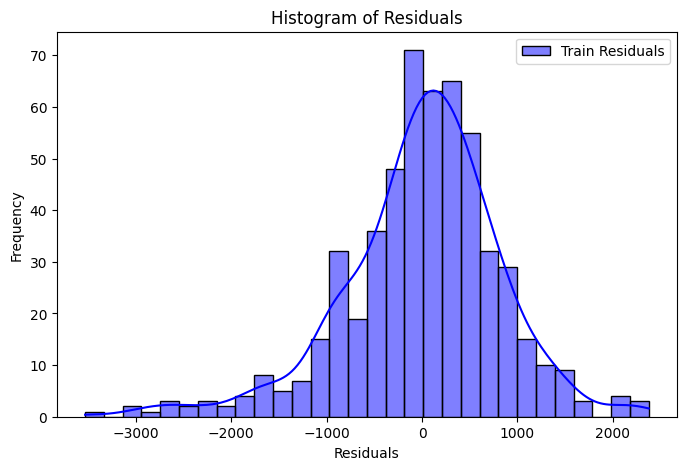

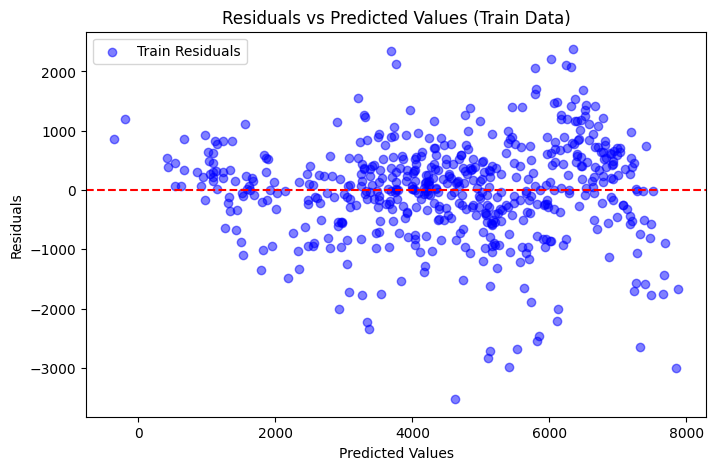

In [37]:
# Residual Analysis for lr3 model

residuals = y_train - y_train_pred_3

# Plot 1: Histogram of residuals
plt.figure(figsize=(8, 5))
sns.histplot(residuals, kde=True, bins=30, color='blue', label='Train Residuals')
plt.title("Histogram of Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# Plot 2: Residuals vs Predicted Values (Train Data)
plt.figure(figsize=(8, 5))
plt.scatter(y_train_pred_3, residuals, color='blue', alpha=0.5, label='Train Residuals')
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs Predicted Values (Train Data)")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.legend()
plt.show()

Errors are normally distributed. <Br>
Errors have no pattern and have constant variance. <Br>
All the assumptions of Linear regression model fits well.

## Model Equation

using model lr3

y = 4550.2413 + (1016.9202 * yr) − (97.6495 * holiday) + (116.1316 * weekday) + (78.8643 * workingday) − (356.0478 * weathersit) +
(
916.5377
*
temp
)
 − 
(
137.5112
*
hum
)
−
(
195.5545
*
windspeed
)
−
(
385.3327
*
season_spring
)
+
(
138.0947
*
season_summer
)
+
(
296.6246
*
season_winter
)
+(916.5377 * temp) − (137.5112 * hum) − (195.5545 * windspeed) − (385.3327 * season_spring) + (138.0947 * season_summer) + (296.6246 * season_winter)

## Conclusion

- Year 2019 had higher demand of bike rentals than 2018.
- If temperatre >= 20°C, chances are higher for renting bikes.
- 'weathersit': If weather is clear or partly cloudy, demand is higher, if weather is cloudy or misty, demand is moderate, if there is rain/snow or thunderstorm, demand is very less.
- 'season': there is very good demand in fall, winter, summer while in spring, demand is very less.
- 'yr', 'temp' affect the demand most and coreelated with 'cnt' positively. After these, the features affecting the demand are 'season' & 'weathersit'